# Cross-validation
This notebook shows how to use cross-validation techniques from [Scikit-learn](https://scikit-learn.org/stable/) to tune parameters.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets

import pysensors as ps

## Setup

First we'll load some training data. In this case, images of handwritten digits.

In [2]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target

n_samples, n_features = X.shape
print(n_samples, n_features)

1083 64


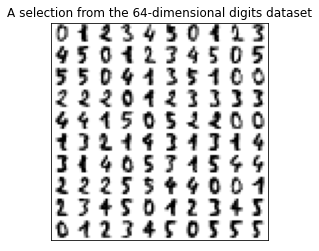

In [3]:
# Plot some digits
n_img_per_row = 10
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')
plt.show()

## Grid search
Here we specify a set of parameter values we'd like to test. The `GridSearchCV` object will try out every possible combination and tell us which gave the best performance.

In [4]:
from sklearn.model_selection import GridSearchCV

model = ps.SensorSelector()

param_grid = {
    "basis": [ps.basis.Identity(), ps.basis.POD(), ps.basis.RandomProjection()],
    "basis__n_basis_modes": [20, 30, 40],
    "n_sensors": [5, 10, 15, 20]
}

search = GridSearchCV(model, param_grid)
search.fit(X, quiet=True)
print("Best parameters:")
for k, v in search.best_params_.items():
    print(f"{k}:  {v}")

Best parameters:
basis:  Identity(n_basis_modes=40)
basis__n_basis_modes:  40
n_sensors:  20


We can also visualize the performance of each candidate model to get a better idea how the different parameters interact. The pandas and seaborn packages help simplify the task.

In [5]:
def generate_summary_plots(results):
    results = pd.DataFrame.from_dict(results)

    # Rename the basis objects for plotting purposes
    def rename_bases(s):
        if 'Identity' in str(s):
            return 'Identity'
        elif 'POD' in str(s):
            return 'POD'
        elif 'RandomProjection' in str(s):
            return 'RandomProjection'
        else:
            return "N/A"

    results['basis'] = results['param_basis'].apply(rename_bases)

    # We were working with the negative mean-square error before
    results['neg_mean_test_score'] = -results['mean_test_score']

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    sns.barplot(data=results, x='param_basis__n_basis_modes', y='neg_mean_test_score', hue='basis', ax=axs[0])
    sns.barplot(data=results, x='param_n_sensors', y='neg_mean_test_score', hue='basis', ax=axs[1])
    axs[0].set(xlabel='n_basis_modes', ylabel='Mean square error')
    axs[1].set(xlabel='n_sensors', ylabel='Mean square error')    
    fig.show()

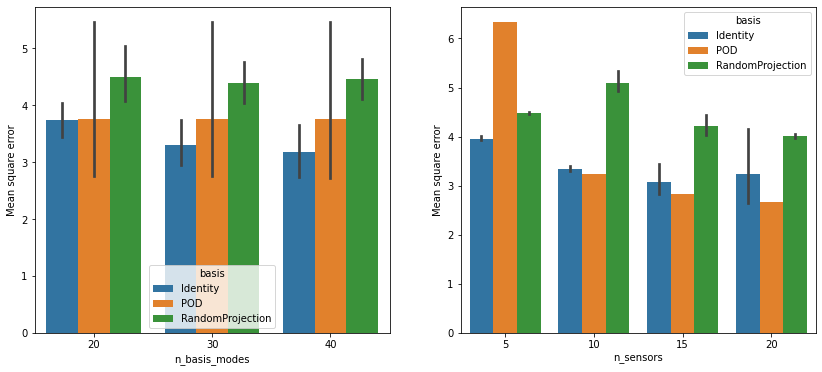

In [6]:
generate_summary_plots(search.cv_results_)

The error bars in the left subplot come from different choices of `n_sensors`. Those on the right come from different values of `n_basis_modes`. Note that the performance of the `POD` basis is more sensitive to low sensor counts than the other two bases, but it does very well once enough sensors are in place. 

## Randomized search

Now suppose we have a fixed sensor budget. We'd like to determine the best basis in which to represent the data to make the most of these sensors. Suppose further that we want to test out a larger number of candidates for `n_basis_modes`. We can obtain a good approximation to the optimal parameter configuration for a fraction of the cost using Scikit-learn's [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) object.

In [7]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

model = ps.SensorSelector(n_sensors=10)

param_distributions = {
    "basis": [ps.basis.Identity(), ps.basis.POD(), ps.basis.RandomProjection()],
    "basis__n_basis_modes": randint(1, 50)
}

search = RandomizedSearchCV(model, param_distributions, n_iter=30)
search.fit(X, quiet=True)
for k, v in search.best_params_.items():
    print(f"{k}:  {v}")

LinAlgError: Matrix is singular.

In [ ]:
results = pd.DataFrame.from_dict(search.cv_results_)

# Rename the basis objects for plotting purposes
def rename_bases(s):
    if 'Identity' in str(s):
        return 'Identity'
    elif 'POD' in str(s):
        return 'POD'
    elif 'RandomProjection' in str(s):
        return 'RandomProjection'
    else:
        return "N/A"

results['basis'] = results['param_basis'].apply(rename_bases)

# We were working with the negative mean-square error before
results['neg_mean_test_score'] = -results['mean_test_score']

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(data=results, x='param_basis__n_basis_modes', y='neg_mean_test_score', hue='basis', ax=axs[0])
sns.barplot(data=results, x='param_n_sensors', y='neg_mean_test_score', hue='basis', ax=axs[1])
axs[0].set(xlabel='n_basis_modes', ylabel='Mean square error')
axs[1].set(xlabel='n_sensors', ylabel='Mean square error')    
fig.show()

In [ ]:
generate_summary_plots(search.cv_results_)

The outcomes of the last two examples suggests that an `Identity` basis with a large number of modes would yield the best reconstruction.